In [1]:
from isochrones.mist import MIST_EvolutionTrack, MIST_Isochrone

track = MIST_EvolutionTrack()

In [102]:
import numpy as np
pivot = 3
delta_pivot = 0.1
masses = np.linspace(1, pivot, 10)
masses2 = np.linspace(pivot, pivot+delta_pivot, 10)
masses = np.concatenate((masses, masses2), axis=0)
true = []
age, feh, distance, AV = 8.5, -0.05, 1000, 0.02
for mass in masses:
# Using return_dict here rather than return_df, because we just want scalar values
  true_props = track.generate(mass, age, feh, distance=distance, AV=AV, return_dict=True)
  true.append(true_props)

In [3]:
len(true)

10

In [103]:
from isochrones import SingleStarModel, get_ichrone

mist = get_ichrone('mist')

uncs = dict(phot=0.02)
prop = []
for true_props in true:
# props = {p: (true_props[p], uncs[p]) for p in ['Teff', 'logg', 'feh']}
  props = ({b: (true_props[b], uncs['phot']) for b in ['G_mag','RP_mag', 'BP_mag']})

# Let's also give an appropriate parallax, in mas
  props.update({'parallax': (1000./distance, 0.1)})
  prop.append(props)

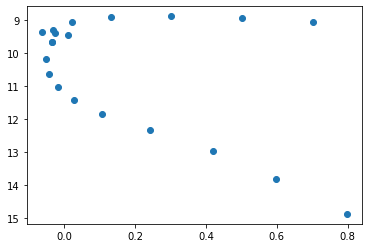

[14.87904097 13.81830405 12.98066555 12.34375437 11.8354033  11.41165047
 11.01351129 10.61382129 10.17708164  9.64288859  9.64288859  9.4381707
  9.36833276  9.34331938  9.29678204  9.04522648  8.90019946  8.87207018
  8.92906134  9.04759777]
[ 0.79710893  0.59876301  0.42076429  0.24157319  0.10769116  0.02856429
 -0.01780478 -0.04328419 -0.05275446 -0.03441026 -0.03441026  0.01187859
 -0.02504878 -0.06220962 -0.03216347  0.02341934  0.13108697  0.30188713
  0.50239197  0.70336268]


In [104]:
def mag(arr, filter):
  return arr[filter][0]
G = np.array(list(map(lambda x: mag(x, "G_mag"), prop)))
R = np.array(list(map(lambda x: mag(x, "RP_mag"), prop)))
B = np.array(list(map(lambda x: mag(x, "BP_mag"), prop)))

from matplotlib import pyplot as plt

plt.scatter(B-R, G)
plt.gca().invert_yaxis()
plt.show()
print(G)
print(B-R)

In [6]:
prop

[{'G_mag': (14.879040969295483, 0.02),
  'RP_mag': (14.397211792090507, 0.02),
  'BP_mag': (15.194320720608612, 0.02),
  'parallax': (1.0, 0.1)},
 {'G_mag': (12.805003802423137, 0.02),
  'RP_mag': (12.563632526577344, 0.02),
  'BP_mag': (12.937138878136624, 0.02),
  'parallax': (1.0, 0.1)},
 {'G_mag': (11.616886145636222, 0.02),
  'RP_mag': (11.575952490239269, 0.02),
  'BP_mag': (11.638313880420878, 0.02),
  'parallax': (1.0, 0.1)},
 {'G_mag': (10.712544771094555, 0.02),
  'RP_mag': (10.735431227379065, 0.02),
  'BP_mag': (10.697378504968308, 0.02),
  'parallax': (1.0, 0.1)},
 {'G_mag': (9.642888590433516, 0.02),
  'RP_mag': (9.664132979845931, 0.02),
  'BP_mag': (9.629722720222421, 0.02),
  'parallax': (1.0, 0.1)},
 {'G_mag': (9.642888590433516, 0.02),
  'RP_mag': (9.664132979845931, 0.02),
  'BP_mag': (9.629722720222421, 0.02),
  'parallax': (1.0, 0.1)},
 {'G_mag': (9.366235954181402, 0.02),
  'RP_mag': (9.38950654728113, 0.02),
  'BP_mag': (9.351811310456982, 0.02),
  'parallax': (

In [111]:
# mods = []
# for props in prop:
#   mod = SingleStarModel(mist, name='gaia', **props)
#   mods.append(mod)

In [105]:
from scipy.stats import norm

def loglikelihood(x, data):
  likelihood = 0
  age, feh, distance, AV, *masses = x
  for mass, dat in zip(masses, data):
    true_props = track.generate(mass, age, feh, distance=distance, AV=AV, return_dict=True)
    for name in dat:
      if(name == "parallax"): 
        if(np.isnan(true_props["distance"])): return -np.inf
        likelihood += norm.logpdf(1000/true_props["distance"], loc=dat[name][0], scale=dat[name][1])
        continue
      if(np.isnan(true_props[name])): return -np.inf
      likelihood += norm.logpdf(true_props[name], loc=dat[name][0], scale=dat[name][1])
  return likelihood


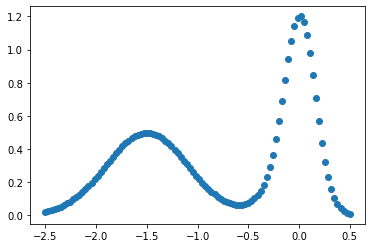

In [106]:
ONE_OVER_ROOT_2PI = 1/(2*np.pi)

def MassPrior(mass):
  if isinstance(mass, np.ndarray) or isinstance(mass, list):
    return np.array(list(map(MassPrior, mass)))
  if(mass <=1):
    # return norm.logpdf(mass, loc=0.079, scale=0.69)
    scale = np.exp(0.079)
    s = 0.69
    y = mass/scale
    return ONE_OVER_ROOT_2PI / (s * y) * np.exp(-0.5 * (np.log(y) / s) ** 2) / scale
  return 0.22915247201304262*np.power(mass, -2.35)
def DistancePrior(distance):
  if isinstance(distance, np.ndarray) or isinstance(distance, list):
    return np.array(list(map(DistancePrior, distance)))
  if distance < 10_000 and distance >=0:
    return 3*np.power(distance, 2)/10_000**3
  return 0
def AgePrior(age):
  if isinstance(age, np.ndarray) or isinstance(age, list):
    return np.array(list(map(AgePrior, age)))
  if age > 5 and age < 10.5:
    return 1/(10.5-5)
  return 0
def AVPrior(AV):
  if isinstance(AV, np.ndarray) or isinstance(AV, list):
    return np.array(list(map(AVPrior, AV)))
  if AV > 0 and AV < 1:
    return 1
  return 0
def FehPrior(feh):
  if isinstance(feh, np.ndarray) or isinstance(feh, list):
    return np.array(list(map(FehPrior, feh)))
  halo_fraction=0.5
  disk_norm = 2.5066282746310007  # integral of the below from -np.inf to np.inf
  disk_fehdist = (
      1.0
      / disk_norm
      * (
          0.8 / 0.15 * np.exp(-0.5 * (feh - 0.016) ** 2.0 / 0.15 ** 2.0)
          + 0.2 / 0.22 * np.exp(-0.5 * (feh + 0.15) ** 2.0 / 0.22 ** 2.0)
      )
  )
  halo_mu, halo_sig = -1.5, 0.4
  halo_fehdist = (
      1.0 / np.sqrt(2 * np.pi * halo_sig ** 2) * np.exp(-0.5 * (feh - halo_mu) ** 2 / halo_sig ** 2)
  )

  return halo_fraction * halo_fehdist + (1 - halo_fraction) * disk_fehdist
x = np.linspace(-2.5,0.5,100)
# ages = 1000
prob = FehPrior(x)
prob
plt.scatter(x, prob)

In [52]:
def logprior(x):
  age, feh, distance, AV, *masses = x
  value = (np.log(AgePrior(age))+
           np.log(FehPrior(feh))+
           np.log(DistancePrior(distance))+
           np.log(AVPrior(AV))+
           np.sum(np.log(MassPrior(masses))))
  return value

In [53]:
def logposterior(x, data):
  posterior = 0
  age, feh, distance, AV, *masses = x
  return loglikelihood(x, data) + logprior(x)

In [108]:
x = (age, feh, distance, AV, *masses)
logposterior(x, prop)

122.32121557439805

In [109]:
len(x)

24

In [120]:
nwalkers = len(x)*2
ndim = len(x)
p0 = []
mult = np.array([0.1,0.01,100,0.02])
mass_mult = np.ones(len(x)-4)*0.2
mult = np.concatenate((mult, mass_mult), axis=0)
for p in range(nwalkers):
  dev = (np.random.rand(ndim)-0.5)*2
  val = np.array([age, feh, distance, AV, *masses])+dev*mult
  p0.append(val)

In [121]:
p0

[array([ 8.45898676e+00, -4.40912642e-02,  1.00159420e+03,  1.74200646e-02,
         1.13018584e+00,  1.12530634e+00,  1.26626971e+00,  1.51470133e+00,
         1.90421483e+00,  2.00905850e+00,  2.39911587e+00,  2.61545635e+00,
         2.76148467e+00,  2.94564529e+00,  2.91296446e+00,  2.83900789e+00,
         3.17249701e+00,  3.04881003e+00,  2.92175164e+00,  3.01131703e+00,
         3.02644324e+00,  3.05182333e+00,  3.20862865e+00,  3.08081767e+00]),
 array([ 8.48987145e+00, -5.38781339e-02,  9.93089187e+02,  9.11053019e-03,
         1.18565119e+00,  1.31218475e+00,  1.61319621e+00,  1.55240743e+00,
         1.96336667e+00,  2.14295959e+00,  2.31225865e+00,  2.45189897e+00,
         2.91744707e+00,  2.94268303e+00,  3.12640812e+00,  2.98374111e+00,
         2.98775790e+00,  2.92446014e+00,  3.08879496e+00,  3.07548096e+00,
         3.26177655e+00,  3.15778001e+00,  3.09687351e+00,  3.02252282e+00]),
 array([ 8.48986096e+00, -5.45304290e-02,  1.00189250e+03,  1.24433818e-02,
        

In [122]:
import os

os.environ["OMP_NUM_THREADS"] = "2"

In [123]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[prop])

In [124]:
state = sampler.run_mcmc(p0, 200)

/tmp/ipykernel_3951/3454121233.py:6: RuntimeWarning: divide by zero encountered in log
  np.log(AVPrior(AV))+
/home/alisyaifudin/Documents/isochrone/emcee/src/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Text(0.5, 0, 'step number')

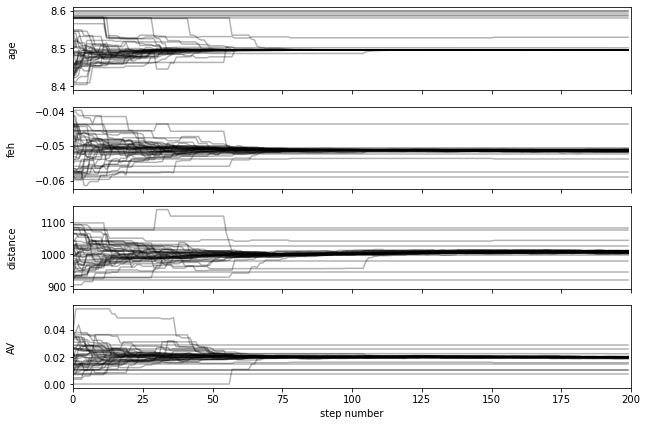

In [125]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["age", "feh", "distance", "AV"]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [126]:
sampler.reset()

In [127]:
sampler.run_mcmc(state, 10000)

/home/alisyaifudin/Documents/isochrone/emcee/src/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/tmp/ipykernel_3951/3454121233.py:6: RuntimeWarning: divide by zero encountered in log
  np.log(AVPrior(AV))+


State([[ 8.49588408e+00 -2.29906509e-02  1.01941628e+03 ...  3.10315521e+00
   3.12297540e+00  3.13510434e+00]
 [ 8.49901613e+00 -5.08525739e-02  1.00346659e+03 ...  3.07809152e+00
   3.08974049e+00  3.10055435e+00]
 [ 8.50205734e+00 -5.82261071e-02  9.99494176e+02 ...  3.07568197e+00
   3.08625866e+00  3.09563650e+00]
 ...
 [ 8.49555215e+00 -4.40634559e-02  1.01127761e+03 ...  3.10187341e+00
   3.11726635e+00  3.13630864e+00]
 [ 8.59372995e+00 -5.88092750e-02  9.46256477e+02 ...  3.10029673e+00
   3.25608381e+00  2.90283671e+00]
 [ 8.58105786e+00 -5.23844625e-02  1.07693438e+03 ...  3.12874289e+00
   3.18264781e+00  3.29808440e+00]], log_prob=[109.73994024 111.88276854 110.55292357 113.55315777 109.10208448
 114.41669739 112.6709987  107.82741133         -inf 112.50013404
 104.63176843 108.83238148 113.34411766 114.09122189 113.69578762
 112.59773204 112.76781712 106.41267477 107.80037963 107.97237371
 116.06939899 110.14177338 113.53277539         -inf 107.74576002
         -inf 112.

Text(0.5, 0, 'step number')

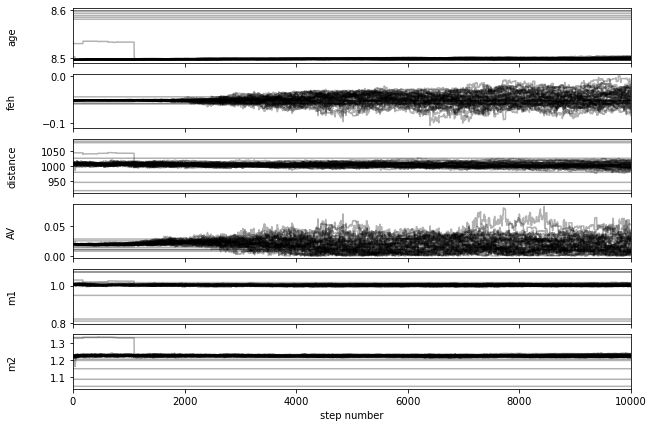

In [128]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["age", "feh", "distance", "AV", "m1", "m2"]
for i in range(6):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

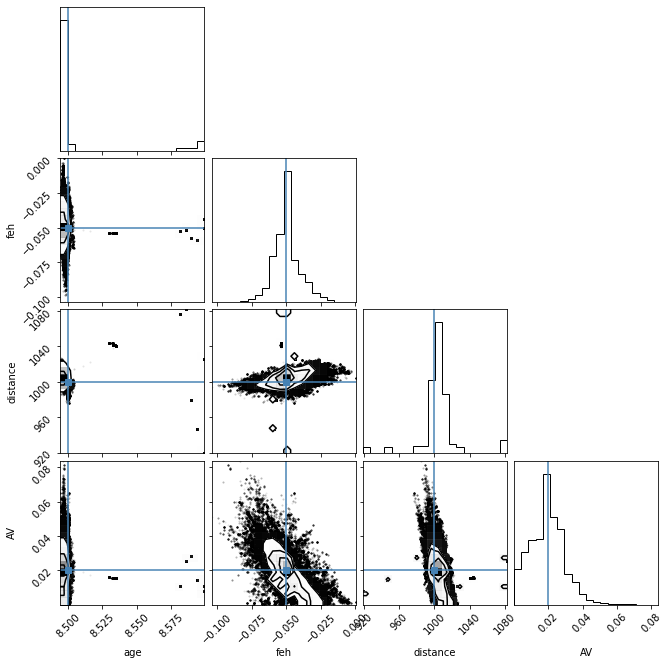

In [129]:
import corner

# samples = sampler.get_chain(discard=2000, flat=True)
samples = sampler.get_chain(flat=True)
fig = corner.corner(
    samples[:,:4], labels=labels, truths=[age, feh, distance, AV]
)

[]

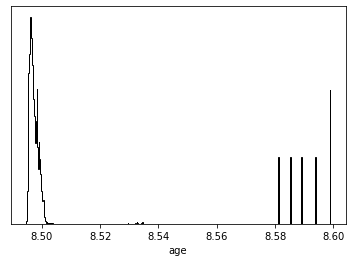

In [136]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], bins=500, color="k", histtype="step")
plt.xlabel("age")
plt.gca().set_yticks([])

In [135]:
len(samples[:, 0])

480000

[]

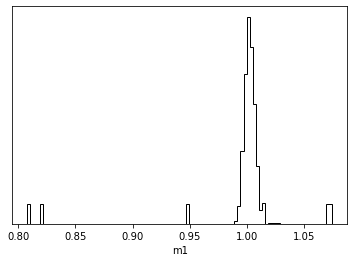

In [131]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 4], bins=100, color="k", histtype="step")
plt.xlabel("m1")
plt.gca().set_yticks([])

3.0


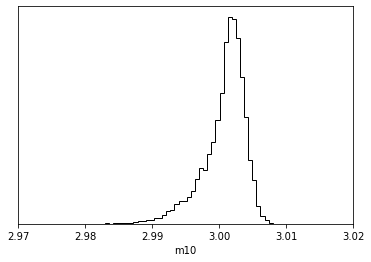

In [168]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 13], bins=500, color="k", histtype="step")
plt.xlim(2.97,3.02)
plt.xlabel("m10")
plt.gca().set_yticks([])
print(masses[9])

In [ ]:
print("age", np.median(samples[:, 0]))

In [132]:

from isochrones.mist import MIST_Isochrone

Mist = MIST_Isochrone()
fage, ffeh, fdistance, fAV = (np.median(samples[:, 0]), 
                              np.median(samples[:, 1]), 
                              np.median(samples[:, 2]), 
                              np.median(samples[:, 3]))

In [137]:
fage, ffeh, fdistance, fAV

(8.497162850490184,
 -0.051026099175121624,
 1004.0371159862631,
 0.019506116720296396)

In [164]:
g, r, b = np.array([]), np.array([]), np.array([])
MASSES = np.linspace(masses[0], 3, 50)
MASSES2 = np.linspace(3, 3.1676, 100)
MASSES = np.concatenate((MASSES,MASSES2), axis=0)
for mass in MASSES:
  eep = mist.get_eep(mass, fage, ffeh, accurate=True)
  pars = [eep, fage, ffeh, fdistance, fAV]
  # pars = [353, 9.78, -1.24]  # eep, log(age), feh
  v = Mist.interp_mag(pars, ['G', 'RP', 'BP'])
  g_i, r_i, b_i = v[-1]
  g = np.append(g, g_i)
  r = np.append(r, r_i)
  b = np.append(b, b_i)

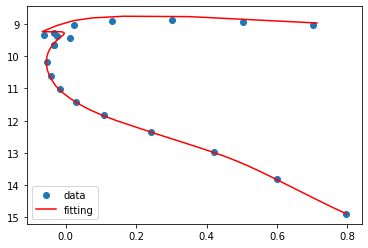

In [165]:
plt.scatter(B-R, G, label="data")
plt.plot(b-r, g, label="fitting", c="r")
plt.gca().invert_yaxis()
plt.legend()
plt.show()